# Processus gaussiens

## JAX

La librairie que nous allons utiliser pour les GPs, [tinygp](https://tinygp.readthedocs.io/en/stable/index.html), utilise [JAX](https://docs.jax.dev/en/latest/index.html).
JAX est une librairie pour l'apprentissage machine, un peu comme PyTorch et Tensorflow, qui permet de tirer avantage des GPUs et TPUs.
Nous couvriront ce type de librairies et leurs avantages lors des cours sur les réseaux neuronaux.
En plus du calcul sur GPU, voici quelques autres avantages de JAX:

- Interface similaire à Numpy (`jax.numpy`)
- Calcul de gradients (`jax.grad`)
- Compilation _just in time_ (JIT) (`jax.jit`)
- Vectorisation automatique (`jax.vmap`)

Bien que JAX permette d'utiliser les GPUs, elle fonctionne aussi sur les CPUs.
Vous pouvez donc installer JAX sur votre ordinateur en suivant les [instructions d'installation](https://docs.jax.dev/en/latest/installation.html#).

Pour offrir les fonctionnalités décrites ci-dessus, JAX fonctionne différement de Numpy à quelques égards.
Ces différences sont présentées dans le tutoriel [🔪 JAX - The Sharp Bits 🔪](https://docs.jax.dev/en/latest/notebooks/Common_Gotchas_in_JAX.html), mais voici les grandes lignes:

- JAX s'attend à des fonctions « pures », c'est à dire qui retournent toujours la même valeur pour les mêmes entrées et n'utilisent pas le contexte "global"
- Les tableaux ne peuvent être modifiés directement. `a[0] = 1.0` devient `a = a.at[0].set(1.0)` ([documentation pour la propriété `at`](https://docs.jax.dev/en/latest/_autosummary/jax.numpy.ndarray.at.html#jax.numpy.ndarray.at))
- Les nombre aléatoires sont générés différemment
- La précision par défaut de JAX pour les nombres réels est 32bit (_single_). Pour utiliser la précision 64bit (_double_), il faut ajouter `jax.config.update("jax_enable_x64", True)` au début du code.

### Définition d'un tableau et modification

Commençons par définir un tableau avec JAX et vérifier que la précision _double_ est bien activée.

In [2]:
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)
a = jnp.arange(5.0)
print("Test")
print(a)
print(a.dtype)

Test
[0. 1. 2. 3. 4.]
float64


On peut voir que modifier le tableau en place donne une erreur.

In [3]:
try:
    a[0] = 1
except TypeError as e:
    print("L'erreur suivante s'est produite!\n")
    print(e)

L'erreur suivante s'est produite!

JAX arrays are immutable and do not support in-place item assignment. Instead of x[idx] = y, use x = x.at[idx].set(y) or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html


Mais que la propriété `at` fonctionne tel qu'attendu:

In [4]:
a = a.at[0].set(100.0)
a

Array([100.,   1.,   2.,   3.,   4.], dtype=float64)

### Fonction et différentiation

Comme avec Numpy, on peut définir une fonction et l'afficher dans un graphique

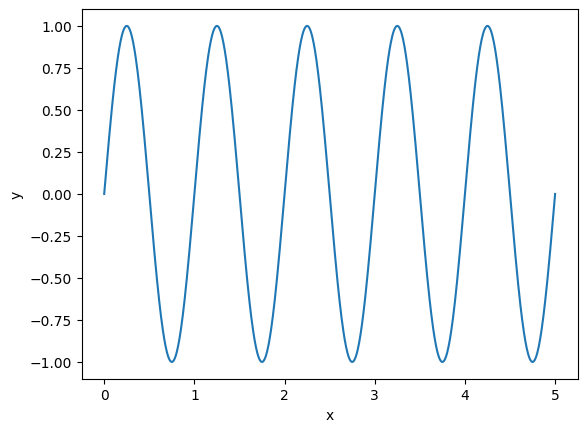

In [5]:
import matplotlib.pyplot as plt

def sinus(x, p):
    A, P, phi, off = p
    return A * jnp.sin(2 * jnp.pi * x / P - phi) + off


x = jnp.linspace(0, 5, num=1000)
params = [1.0, 1.0, 0.0, 0.0]
y = sinus(x, params)

plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Mais comme la fonction utilise `jax.numpy`, on peut obtenir un gradient avec `jax.grad`.
La fonction `jax.grad` accepte seulement les fonctions qui retournent un scalaire.
C'est ici que la fonction `jax.vmap` devient utile: elle permet d'appliquer notre fonction de gradient sur plusieurs `x`.


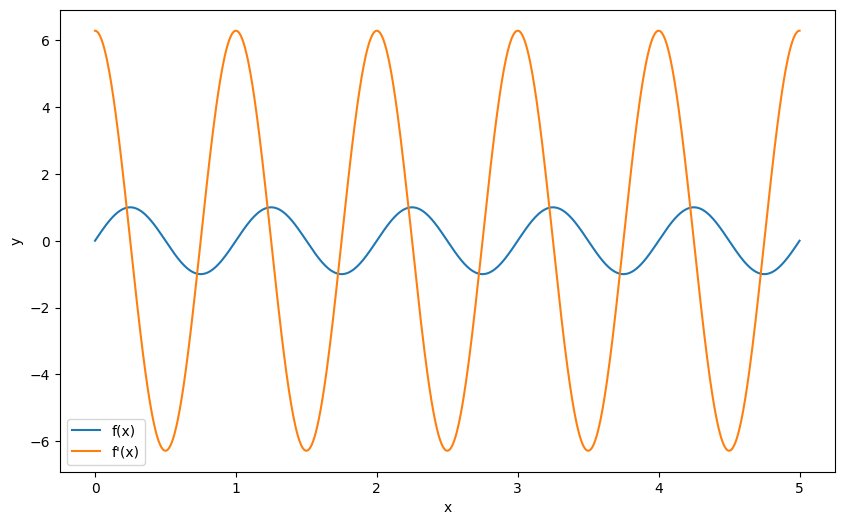

In [6]:
sinus_grad = jax.grad(sinus)  # grad se fait sur le 1er argument par défaut
# on doit dire à vmap sur quels arguments opérer:
# - axe 0 du premier argument
# - aucun axe du 2e argument
yp = jax.vmap(sinus_grad, in_axes=(0, None))(x, params)

plt.figure(figsize=(10, 6))
plt.plot(x, y, label="f(x)")
plt.plot(x, yp,label="f'(x)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

### Compilation _just in time_ (JIT)

On peut également créer une version compilé de notre fonction avec `jax.jit`.
Lors de la première évaluation, la fonction sera compilée et sera ainsi plus rapide les fois suivantes.
On peut utiliser `%timeit` pour tester l'accélération.
(Ici, `block_until_read()` s'assure seulement que JAX n'accélère pas l'évaluation avec le _dispatch_ asynchrone).

In [7]:
xtest = jnp.linspace(0.0, 10.0, num=1_000_00)
%timeit sinus(xtest, params).block_until_ready()

667 μs ± 40 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Si on utilise `jit`, on peut accélérer la fonction.

In [8]:
sinus_jit = jax.jit(sinus)
_ = sinus_jit(x, params)  # On compile en exécutant une première fois
%timeit sinus_jit(xtest, params).block_until_ready()  # On teste la version compilée

515 μs ± 42.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Dans ce cas-ci, la fonction est plutôt simple et le temps gagné n'est pas énorme.
Par contre, plus nos modèles sont complexes, plus la compilation JIT sera utile.

`jax.jit` peut aussi être utilisée comme décorateur sur notre fonction, par exemple

In [9]:
@jax.jit
def sinus_jit_deco(x, p):
    A, P, phi, off = p
    return A * jnp.sin(2 * jnp.pi * x / P - phi) + off

_ = sinus_jit_deco(x, params)  # On compile
%timeit sinus_jit_deco(xtest, params).block_until_ready()  # On teste la version compilée

529 μs ± 56.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Ces deux méthodes sont équivalentes.

### Nombres aléatoires

Avec JAX, les nombres aléatoires sont générés un peu différemment d'avec Numpy.
Pour opérer sur des fonctions « pures », il faut que l'état du générateur aléatoire soit passé en argument aux différentes fonctions.
On fait ceci à l'aide d'une « clé », qui peut être divisée autant de fois que nécessaire pour générer de nouveaux nombres.

In [10]:
key = jax.random.key(3051)
print(key)

Array((), dtype=key<fry>) overlaying:
[   0 3051]


Une clé donnée génère toujours la même valeur

In [11]:
print(jax.random.normal(key))
print(jax.random.normal(key))

-1.278167993100484
-1.278167993100484


Pour obtenir de nouveaux nombres, il faut diviser la clé en une nouvelle `key` et une `subkey`.
On utilise la `subkey` pour générer des nombres aléatoires.
La nouvelle `key` sera re-divisée plus loin dans notre code au besoin.

In [12]:
for _ in range(4):
    key, subkey = jax.random.split(key)
    print(jax.random.normal(subkey))

0.5328411343779211
0.33692105877614514
-1.152171978695814
-0.1276830979195066


**Exercice: Générez des nombres tirées d'une distribution normale 2D centrée à [0, 5] avec une une matrice la matrice de covariance diagonale ci-dessous. Affichez les échantillons sur un histogramme 2D (`plt.hist2d` ou `corner.corner`).**

$$
C = \begin{bmatrix}1 & 0\\ 0 & 2\end{bmatrix}
$$

(La distribution normale multidimensionnelle est `multivariate_normal` dans NumPy et JAX).

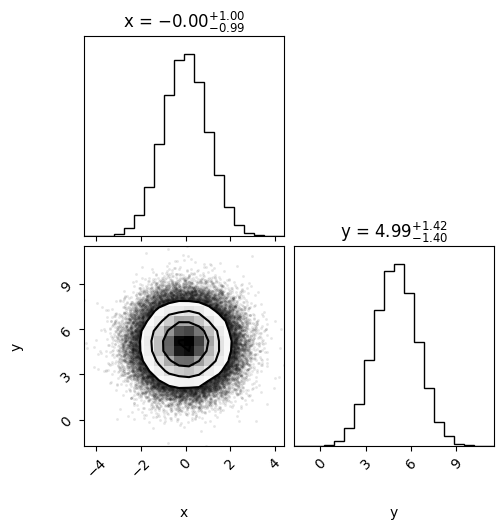

In [31]:
key, subkey = jax.random.split(key)
samples = jax.random.multivariate_normal(
    subkey, jnp.array([0, 5]), jnp.array([[1, 0], [0, 2]]), shape=(100_000,)
)

corner.corner(np.array(samples), show_titles=True, labels=["x", "y"])
plt.show()

Voilà! La section ci-dessus couvrait les principales choses à savoir avant d'utiliser JAX.

## Processus gaussiens (implémentation)

Tel que vu en classe, les processus gaussiens (GPs) sont mathématiquement assez simple.
Il est donc possible de les implémenter avec `numpy` ou `jax.numpy`.

Les équations dont nous avons besoin sont données aux diapositives 12, 15 et 23.

### Fonction de covariance

Commençons par définir une fonction de covariance (_kernel_) exponentielle carrée.

$$
k_{\mathrm{SE}}(x_i, x_j, \{\lambda\}) = \exp{\left(-\frac{1}{2\lambda^2}\left|x_i - x_j\right|^2\right)}
$$

**Implémentez l'équation ci-dessus et affichez sont résultat pour $x_i$ entre -5 et 5. Gardez $x_j$ fixe à 0.**
**Utilisez une échelle $\lambda = 1$.**

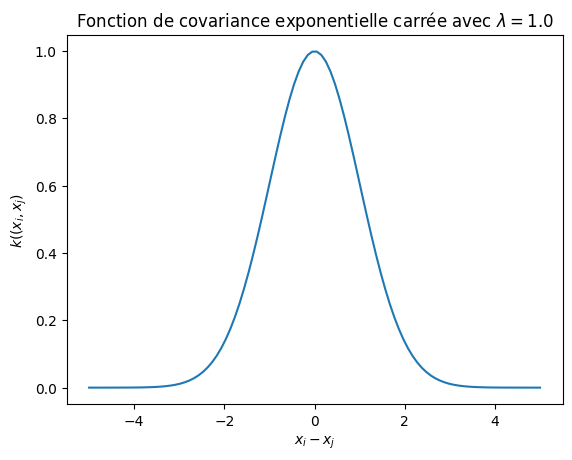

In [17]:
def kernel(xi, xj, scale=1.0):
    return jnp.exp(-0.5 * scale**-2 * (xi - xj)**2)

xi = jnp.linspace(-5, 5, num=100)
xj = 0.0
k = kernel(xi, xj)

plt.plot(xi - xj, k)
plt.xlabel("$x_i - x_j$")
plt.ylabel("$k((x_i,x_j)$")
plt.title(r"Fonction de covariance exponentielle carrée avec $\lambda=1.0$")
plt.show()

La fonction nous indique que les points étant à près les uns des autres sont très corrélés, mais qu'au delà de $|x_i - x_j| > 4$, la corrélation est presque 0.

On peut visualiser cette corrélation d'une autre manière, en utilisant deux vecteurs et en regardant la distance point-par-point.

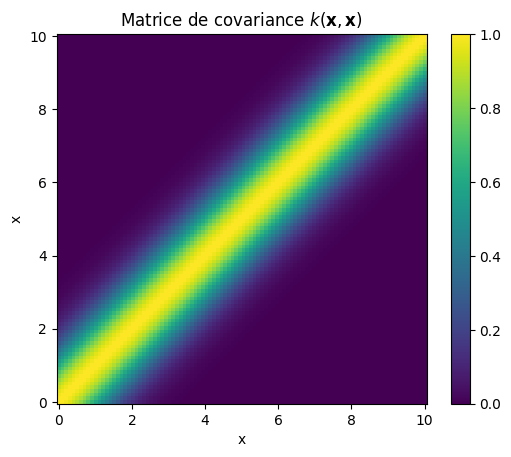

In [13]:
xi = jnp.linspace(0, 10, num=100)
xim, xjm = jnp.meshgrid(xi, xi)
kmat = kernel(xim, xjm)
plt.pcolormesh(xi, xi, kmat)
plt.xlabel("x")
plt.ylabel("x")
plt.title(r"Matrice de covariance $k(\mathbf{x},\mathbf{x})$")
plt.gca().set_aspect("equal")
plt.colorbar()
plt.show()

### Distribution a priori

Comme un GP est une distribution gaussienne sur les fonctions, on peut utiliser la matrice de covariance `kmat` pour générer des évaluations $\mathbf{y} = f(\mathbf{x})$ tirées de cette distribution.
Notre fonction moyenne dans ce cas-ci sera simplement une constante autour de 0.

**Utilisez `jax.random.multivariate_normal()` pour générer 5 échantillons d'une distribution avec une moyenne de 0 et une covariance `kmat`.**
**Utilisez l'argument `method="svd"` pour éviter les erreurs numériques.**

In [14]:
key, subkey = jax.random.split(key)
gp_mean = jnp.zeros_like(xi)
gp_prior_samples = jax.random.multivariate_normal(subkey, gp_mean, kmat, method="svd", shape=(5))
gp_prior_samples.shape

(5, 100)

La distribution normale à 100 dimension nous retourne donc 5 vecteurs $y$ évalués aux valeurs de notre fonction.
On peut les afficher sur un même graphique pour voir quel type de fonctions le GP retourne.

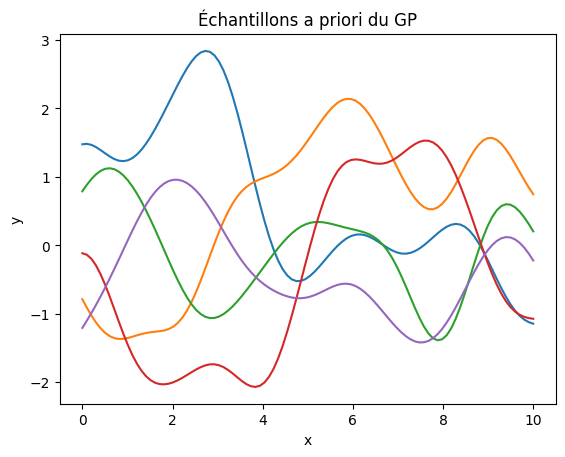

In [15]:
plt.plot(xi, gp_prior_samples.T)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Échantillons a priori du GP")
plt.show()

Ces échantillons sont tirées de la distribution **a priori** du GP.
Ils ne sont donc conditionnés sur aucunes données, ce qui les rend très peu utiles en pratique.

### Distribution a posteriori (conditionnelle)

On peut simuler quelques points de données et utiliser les équations de la page 23 pour obtenir la distribution **a posterori** du GP conditionnée sur ces observations.

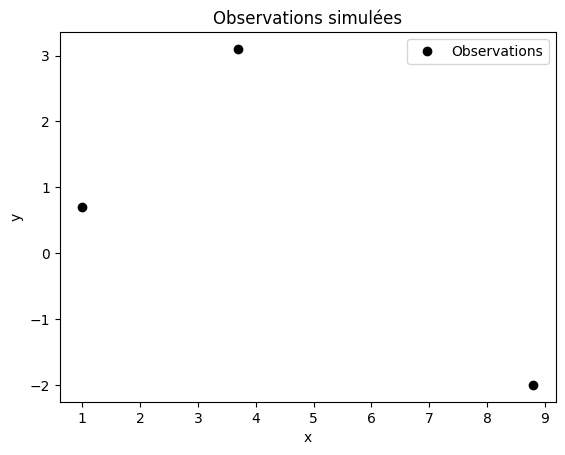

In [18]:
key, subkey1, subkey2 = jax.random.split(key, num=3)
x = jax.random.uniform(subkey1, shape=5, minval=0.5, maxval=9.0)
y = jax.random.normal(subkey2, shape=x.shape)
xt = jnp.linspace(0, 10, num=100)

plt.plot(x, y, "ko", label="Observations")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Observations simulées")
plt.legend()
plt.show()

Maintenant que nous avons des observations, nous pouvons générer des échantillons de la distribution a posteriori (conditionnelle) du GP.
Dans ces équations $x$ et $y$ dénotent les vecteurs d'observations.
$x_\star$ est le vecteur points où l'on veut prédire $y_\star$ (`xt` dans le code).
La distribution conditionnelle est donnée à la page 23 de diapositives. Il faut d'abord évaluer trois matrices de covariance

$$
K = k(x, x), K_\star = k(x,x_\star), K_{\star\star} = k(x_\star, x_\star).
$$

La distribution conditionnelle d'un GP est aussi une distribution gaussienne multidimensionnelle, mais sa moyenne et sa covariance sont différentes de la distribution a priori:

$$
p(y_{\star}|y) = \mathcal{N}(f_\star, C_\star)
$$

où la moyenne est

$$
f_\star = m_\star + K_{\star}^T K^{-1} (y - m)
$$

et la covariance

$$
C_\star = K_{\star\star} + K_{\star}^T K^{-1} K_{\star}.
$$

- **Utilisez ces équations pour obtenir la distribution conditionnelle du GP**. Il s'agit d'une distribution normale à plusieurs dimensions. Le nombre de dimension est le nombre de points dans ce cas-ci. Les dimensions seront inférées automatiquement par Numpy ou JAX lorsque vous passez le vecteur moyenne $f_{\star}$ et la matrice de covariance $C_{\star}$ en argument.
- **Une fois cette distribution obtenue, affichez la moyenne $f_{\star}$ superposée aux données.**
- **Affichez également un intervalle `fill_between` autour de la moyenne en utilisant l'écart type dérivé de $C_{\star}$** (indice: la variance se trouve sur la diagonale de $C_{\star}$).
- **Affichez aussi 5 échantillons tirés de la distribution a posteriori du GP**

<details>
    
<summary>Quelques indices (cliquer pour afficher)</summary>

1. Utilisez `kernel(x[:, None], x[None, :])` pour facilement vectoriser le calcul de la matrice de covariance
2. Les fonctions `jnp.linalg`, `jnp.diag` et l'opération de multiplication matricielle `@` seront utiles.
3. Pour générer les échantillons, le code du prior peut être réutilisé, mais il faut changer la moyenne et la covariance. N'oubliez pas de re-diviser la clé!
</details>

In [19]:
K = kernel(x[:, None], x[None, :])
Ks = kernel(x[:, None], xt[None, :])
Kss = kernel(xt[:, None], xt[None, :])
mstar = jnp.zeros_like(xt)

Km1 = jnp.linalg.inv(K)
fs = mstar + Ks.T @ Km1 @ y
Cs = Kss - Ks.T @ Km1 @ Ks
f_std = jnp.sqrt(jnp.diag(Cs))

key, subkey = jax.random.split(key)
gp_post_samples = jax.random.multivariate_normal(subkey, fs, Cs, method="svd", shape=(5))

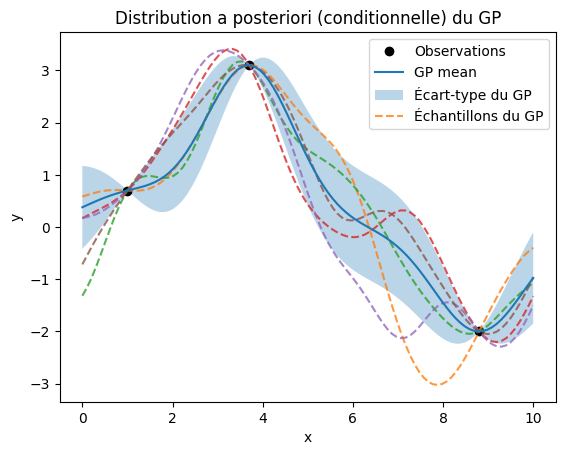

In [20]:
plt.plot(x, y, "ko", label="Observations")
plt.plot(xt, fs, label="GP mean", zorder=10)
plt.fill_between(xt, fs - f_std, fs + f_std, alpha=0.3, label="Écart-type du GP")
plt.plot(xt, gp_post_samples.T, "--", label=["Échantillons du GP"] + [None] * gp_post_samples[:-1].shape[0], alpha=0.8)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Distribution a posteriori (conditionnelle) du GP")
plt.show()

## Exploration

Quelques suggestions:

- Tentez de modifier l'hyperparamètre $\lambda$ comment cela affecte-t-il vos résultats?
- Testez d'autres fonction de covariances
- Implémentez l'équation du _likelihood_ (diapositive 28) pour le GP et tentez d'optimiser l'hyperparamètre pour ce problème simple.
- Comment se comporte le temps de calcul du GP en ajoutant des observations?
- Commencez à explorer la documentation de [tinygp](https://tinygp.readthedocs.io/en/stable/index.html).

**C'est possible que vous obteniez des instabilités numériques aux 4 premières questions. Ne perdez pas trop de temps là dessus si c'est le cas. C'est entre autre pourquoi nous utiliserons tinygp lors du prochain cours**.